In [261]:
import pandas as pd
import numpy as np
import torch

# Hardware Check

In [262]:
!nvidia-smi

Mon Oct 27 14:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:2B:00.0  On |                  N/A |
|  0%   51C    P8             18W /  170W |    1230MiB /  12288MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [263]:
#check if GPU is available and print device name
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060


# Dataset 

In [264]:
labels_df = pd.read_csv('labels.csv',names=['lat','lng','label1','label2','label3', 'filename'])

In [265]:
total_rows_len = len(labels_df)
print(f"\nTotal number of rows: {total_rows_len}")
labels_df.head()


Total number of rows: 2178


,lat,lng,label1,label2,label3,filename
0,10.328221,-20.476357,FR II,NaN,NaN,NaN
1,92.109802,-49.431413,typical,NaN,NaN,NaN
2,88.916825,-59.431868,Point Source,NaN,NaN,NaN
3,5.457981,-25.589637,FR II,NaN,NaN,NaN
4,119.417608,-53.396711,FR II,NaN,NaN,NaN


In [266]:

import os

#concatenate the directory to the filenames
filenames = ['Data/typ/typ_PNG/' + f for f in os.listdir('Data/typ/typ_PNG')] + ['Data/exo/exo_PNG/' + f for f in os.listdir('Data/exo/exo_PNG')]
print(f"Total number of files: {len(filenames)}")

# Print first 5 filenames
for i in range(5):
    print(filenames[i])

Total number of files: 2108
Data/typ/typ_PNG/0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.316 -24.707_[0.0166409 0.0166409] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.327 -24.571_[0.02705031 0.02705031] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.371 -24.554_[0.009 0.009] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.425 -25.211_[0.02334787 0.02334787] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png


In [267]:
print(labels_df.dtypes)

lat         float64
lng         float64
label1       object
label2       object
label3       object
filename    float64
dtype: object


## Image to Label mapping

In [268]:
for i, filename in enumerate(filenames,start=0):
    #drop the directory path
    truncated_filename = os.path.basename(filename)
    coordinates = truncated_filename.split('_')[0]
    if coordinates.count(' ') != 1:
        print(f"Skipping filename with unexpected format: {truncated_filename}")
        continue
    
    lat, lng = coordinates.split(' ')
    lat, lng = float(lat), float(lng)
   
    label_row = labels_df[(labels_df['lat'].round(3) == lat) & (labels_df['lng'].round(3) == lng)]
    if not label_row.empty:
        labels_df.loc[label_row.index, 'filename'] = filename

C:\Users\User\AppData\Local\Temp\ipykernel_3508\1551268953.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Data/typ/typ_PNG/0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labels_df.loc[label_row.index, 'filename'] = filename


Skipping filename with unexpected format: .ipynb_checkpoints


In [269]:
def label_to_image_mapper(folder, labels_df):
    
    new_df = pd.DataFrame(columns=labels_df.columns)
    # print(f'{folder}/typ/typ_PNG/')
    filenames = [f'{folder}/typ/typ_PNG/' + f for f in os.listdir(f'{folder}/typ/typ_PNG')] + [f'{folder}/exo/exo_PNG/' + f for f in os.listdir(f'{folder}/exo/exo_PNG')]
    print(f"Total number of files: {len(filenames)}")

    # Print first 5 filenames
    for i in range(1):
        print(filenames[i])

    for i, filename in enumerate(filenames,start=0):
        #drop the directory path
        truncated_filename = os.path.basename(filename)
        coordinates = truncated_filename.split('_')[0]
        
        if coordinates.count(' ') != 1:
            print(f"Skipping filename with unexpected format: {truncated_filename}")
            continue
        
        lat, lng = coordinates.split(' ')
        lat, lng = float(lat), float(lng)
    
        label_row = labels_df[(labels_df['lat'].round(3) == lat) & (labels_df['lng'].round(3) == lng)]
        if not label_row.empty:
            #insert row to new dataframe
            new_row = label_row.copy()
            new_row['filename'] = filename
            new_df = pd.concat([new_df, new_row], ignore_index=True)

    return new_df

In [270]:
# labels_df = label_to_image_mapper('Data', labels_df)

In [271]:
labels_df.head()

,lat,lng,label1,label2,label3,filename
0,10.328221,-20.476357,FR II,NaN,NaN,Data/typ/typ_PNG/10.328 -20.476_[0.01424399 0....
1,92.109802,-49.431413,typical,NaN,NaN,Data/typ/typ_PNG/92.110 -49.431_[0.04121882 0....
2,88.916825,-59.431868,Point Source,NaN,NaN,Data/typ/typ_PNG/88.917 -59.432_[0.009 0.009] ...
3,5.457981,-25.589637,FR II,NaN,NaN,Data/typ/typ_PNG/5.458 -25.590_[0.009 0.009] d...
4,119.417608,-53.396711,FR II,NaN,NaN,Data/typ/typ_PNG/119.418 -53.397_[0.009 0.009]...


## Missed labels

In [272]:
missed_labels_df = labels_df[labels_df['filename'].isnull()]
print(f"\nNumber of missed labels (filename is null): {len(missed_labels_df)}")
missed_labels_df.head()


Number of missed labels (filename is null): 202


,lat,lng,label1,label2,label3,filename
8,351.664270,-40.441765,Should be discarded,NaN,NaN,NaN
10,3.751163,-29.920867,Should be discarded,NaN,NaN,NaN
18,172.646749,-41.932433,Should be discarded,NaN,NaN,NaN
20,97.471185,-56.563903,Should be discarded,NaN,NaN,NaN
23,61.156721,-71.298579,Should be discarded,NaN,NaN,NaN


In [273]:
missed_labels_df['label1'].value_counts()

label1
Should be discarded    130
Point Source            45
FR II                   14
Bent                     8
FR I                     5
Name: count, dtype: int64

In [274]:
labels_df['label1'].value_counts()

label1
FR II                  683
Point Source           442
FR I                   431
Bent                   428
Should be discarded    130
typical                 24
Exotic                  18
S/Z shaped              17
X-Shaped                 5
Name: count, dtype: int64

In [275]:
labels_df['label2'].value_counts()

label2
Bent                   97
Should be discarded    69
Exotic                 33
S/Z shaped              4
X-Shaped                1
Name: count, dtype: int64

In [276]:
labels_df['label3'].value_counts()

label3
Exotic                 5
Should be discarded    1
Name: count, dtype: int64

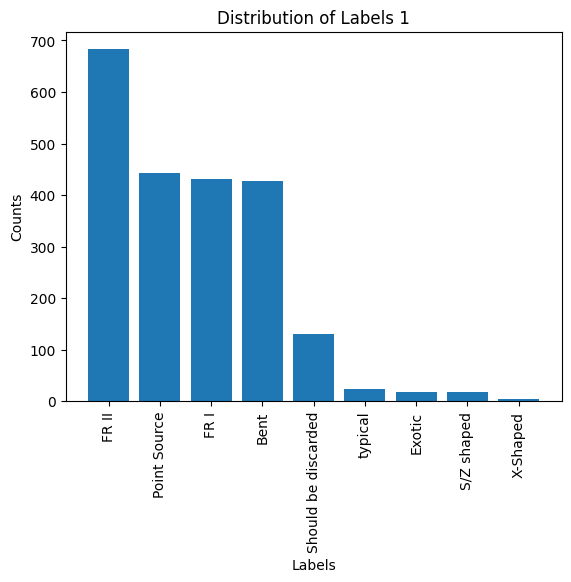

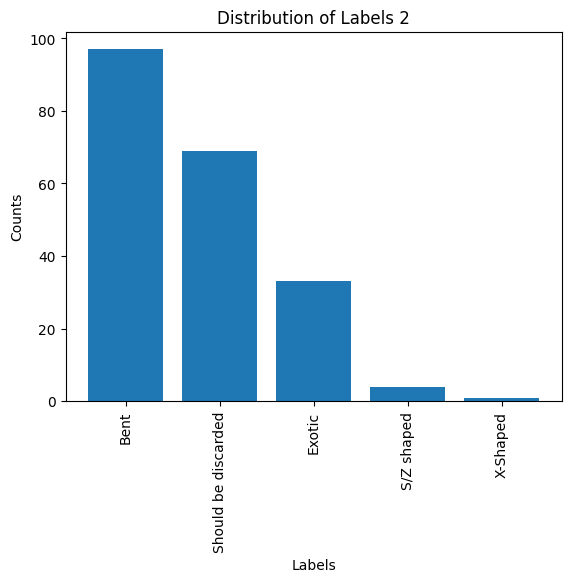

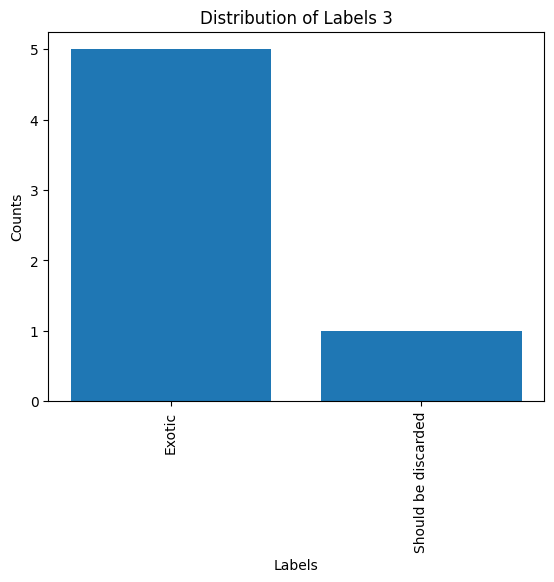

In [277]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

for i in range(len(['label1','label2','label3'])):
    label_counts = labels_df[f'label{i+1}'].value_counts()
    plt.bar(label_counts.index, label_counts.values)
    plt.xticks(rotation=90)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Distribution of Labels {i+1}')
    plt.show()

## Collapsed Labels

In [278]:
def collapse_labels(labels_df):
    collapsed_df = labels_df.melt(
        id_vars=['lat', 'lng', 'filename'],
        value_vars=['label1', 'label2', 'label3'],
        var_name='label_type',
        value_name='label'
    )
    collapsed_df.drop(columns=['label_type'], inplace=True)
    collapsed_df.dropna(subset=['label'], inplace=True)
    collapsed_df.reset_index(drop=True, inplace=True)

    total_rows_len = len(collapsed_df)
    print(f"\nTotal number of rows: {total_rows_len}")
    return collapsed_df

In [279]:
collapsed_label_df = collapse_labels(labels_df)
collapsed_label_df.head()


Total number of rows: 2388


,lat,lng,filename,label
0,10.328221,-20.476357,Data/typ/typ_PNG/10.328 -20.476_[0.01424399 0....,FR II
1,92.109802,-49.431413,Data/typ/typ_PNG/92.110 -49.431_[0.04121882 0....,typical
2,88.916825,-59.431868,Data/typ/typ_PNG/88.917 -59.432_[0.009 0.009] ...,Point Source
3,5.457981,-25.589637,Data/typ/typ_PNG/5.458 -25.590_[0.009 0.009] d...,FR II
4,119.417608,-53.396711,Data/typ/typ_PNG/119.418 -53.397_[0.009 0.009]...,FR II


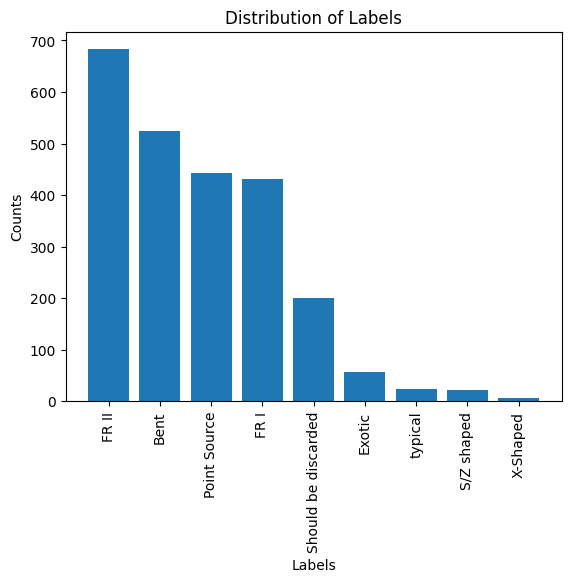

In [280]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

label_counts = collapsed_label_df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title(f'Distribution of Labels')
plt.show()


Label: FR II


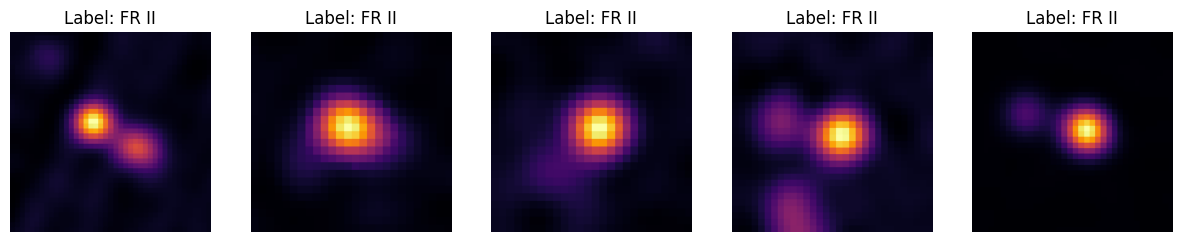


Label: typical


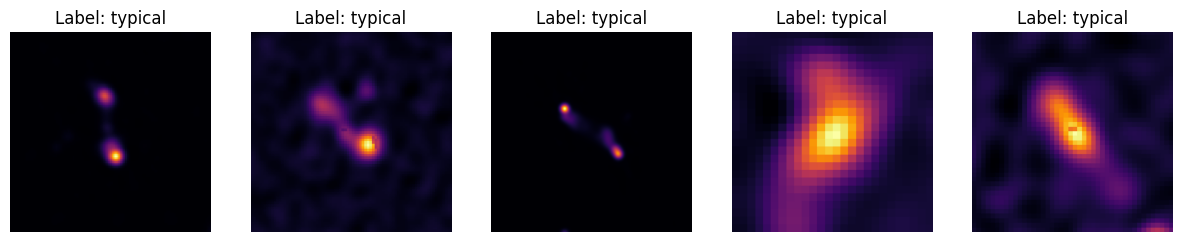


Label: Point Source


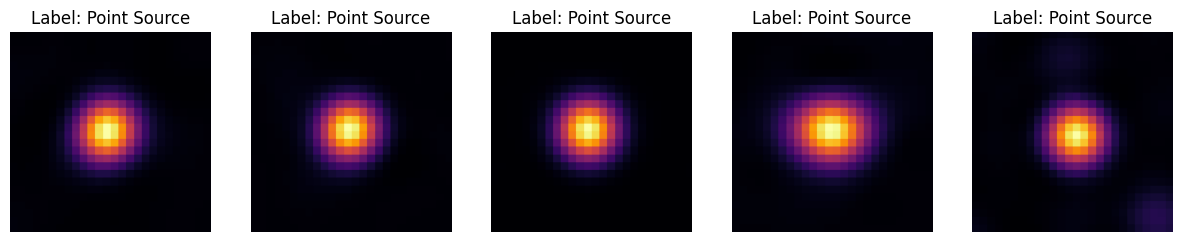


Label: Bent


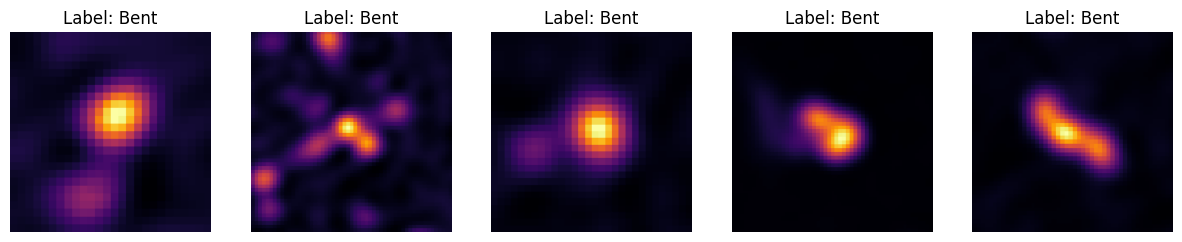


Label: Should be discarded


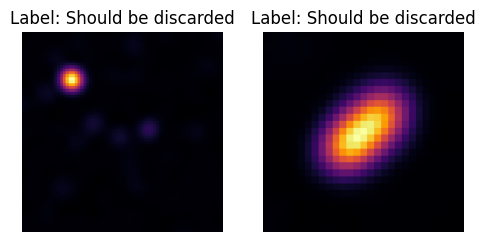


Label: FR I


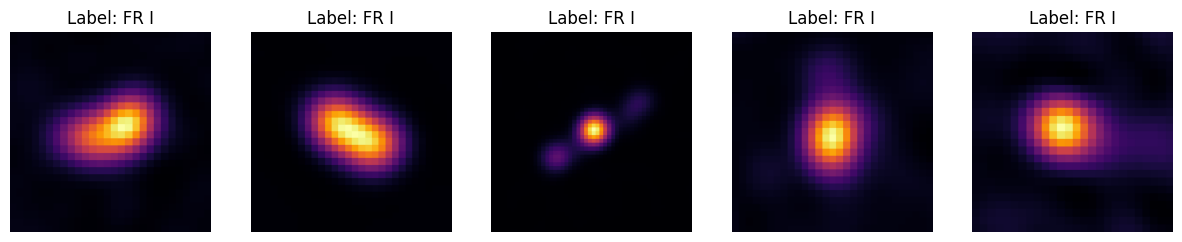


Label: Exotic


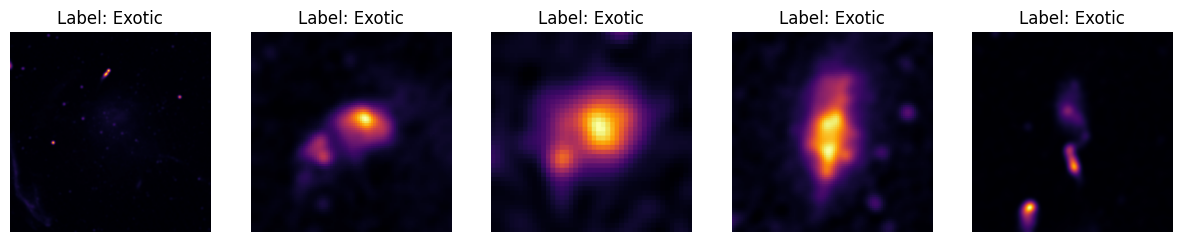


Label: S/Z shaped


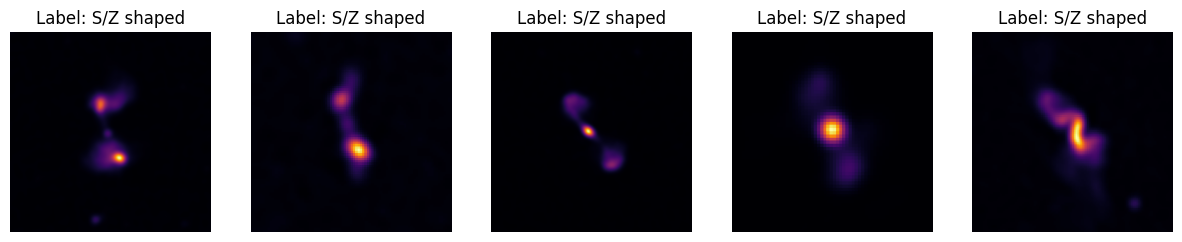


Label: X-Shaped


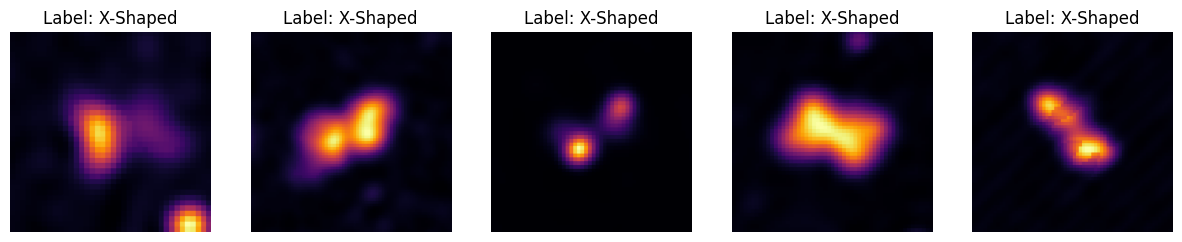

In [281]:
# print 5 images from each label category in label1
import matplotlib.image as mpimg
unique_labels = collapsed_label_df['label'].unique()
for label in unique_labels:
    label_filenames = collapsed_label_df[collapsed_label_df['label'] == label]['filename'].dropna().tolist()
    print(f"\nLabel: {label}")
    # print the files in one row
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(label_filenames[:5]):
        img = mpimg.imread(filename)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")

    
    plt.show()

In [282]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [283]:
# Define augmentation pipeline for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),              # Convert image to PyTorch tensor
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(15),     # Randomly rotate by +/- 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
])

In [284]:
#combine Data/typ/typ_PNG and Data/exo/exo_PNG into a single dataset with the defined transformations
# dataset_typ = ImageFolder(root='Data/typ', transform=train_transform)
# dataset_exo = ImageFolder(root='Data/exo', transform=train_transform)
# dataset = torch.utils.data.ConcatDataset([dataset_typ, dataset_exo])



In [285]:
# print("Number of datasets combined:", len(dataset.datasets))
# for i, ds in enumerate(dataset.datasets):
#     print(f"Dataset {i} - Number of samples: {len(ds)}")

In [286]:
output_dir_typ = 'Augmented_Data/typ/typ_PNG'
output_dir_exo = 'Augmented_Data/exo/exo_PNG'

os.makedirs(output_dir_typ, exist_ok=True)
os.makedirs(output_dir_exo, exist_ok=True)

In [287]:
#check if path exists and if is empty
if os.path.exists(output_dir_typ):
    print(f"Directory {output_dir_typ} exists.")
    if not os.listdir(output_dir_typ):
        print(f"Directory {output_dir_typ} is empty.")
    else:
        print(f"Directory {output_dir_typ} is not empty.")

if os.path.exists(output_dir_exo):
    print(f"Directory {output_dir_exo} exists.")
    if not os.listdir(output_dir_exo):
        print(f"Directory {output_dir_exo} is empty.")
    else:
        print(f"Directory {output_dir_exo} is not empty.")

Directory Augmented_Data/typ/typ_PNG exists.
Directory Augmented_Data/typ/typ_PNG is not empty.
Directory Augmented_Data/exo/exo_PNG exists.
Directory Augmented_Data/exo/exo_PNG is not empty.


## Generate new images

In [288]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image

# Loop through each image and apply augmentations
num_augmentations = 5
# print(dataset.datasets)

images = labels_df['filename'].dropna().tolist()
for image in images:
    original_img = Image.open(image).convert('RGB')
    truncated_filename = os.path.basename(image)
    coordinates = truncated_filename.split('_')[0]
    
    full_save_path = None
    folder = 'Augmented_Data'
    subfolder = ''
    category = ''
    
    if 'typ' in image:
        subfolder = 'typ'
        category = 'typ_PNG'
    elif 'exo' in image:
        subfolder = 'exo'
        category = 'exo_PNG'
    

    
    for i in range(num_augmentations+1):
        
        augmented_img = None
        # add original image as first image resized to 224x224
        if i==0:
            augmented_img = transforms.Resize((224, 224))(transforms.ToTensor()(original_img))
        else:
            augmented_img = train_transform(original_img)
        
        new_filename = f"{coordinates}_aug_{i+1}.png"
        # Determine output directory based on dataset root
        # Save only if not already present
        full_save_path = os.path.join(folder, subfolder, category, new_filename)
        #save empty text file
       
        # Make sure the parent directories exist
        os.makedirs(os.path.dirname(full_save_path), exist_ok=True)

        # Check if the file exists before saving
        if not os.path.exists(full_save_path):
            # Convert tensor to PIL Image and save as PNG
            pil_img = to_pil_image(augmented_img)
            pil_img.save(full_save_path)
            print("✅ Augmented image saved to:", full_save_path)
        else:
            print(f"File already exists: {full_save_path}")

File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_2.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_3.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_4.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_5.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_6.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_2.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_3.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_4.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_5.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_6.png
File already exists: Augmented_Data\typ\typ_PNG\88.917 -59.432_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\88.

In [289]:
augmented_img_df = label_to_image_mapper('Augmented_Data', labels_df)
collapsed_augmented_label_df = collapse_labels(augmented_img_df)

Total number of files: 12066
Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_1.png


C:\Users\User\AppData\Local\Temp\ipykernel_3508\3247669299.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)



Total number of rows: 12708


In [290]:
collapsed_augmented_label_df.head()

,lat,lng,filename,label
0,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_1...,FR II
1,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_2...,FR II
2,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_3...,FR II
3,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_4...,FR II
4,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_5...,FR II


# CNN

In [291]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  94958 KiB |  94958 KiB | 663426 KiB | 568468 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  94958 KiB |  94958 KiB | 663426 KiB | 568468 KiB |
|---------------------------------------------------------------------------|
| Requested memory      |  92108 KiB |  92108 KiB | 644757 KiB | 552649 KiB |
|---------------------------------------------------------------

In [292]:
# consider VGG16
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# Replace final layer

num_classes = labels_df['label1'].nunique()
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [293]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [294]:
# Training Loop (simplified):
train_losses = []

for epoch in range(1):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

NameError: name 'dataloader' is not defined

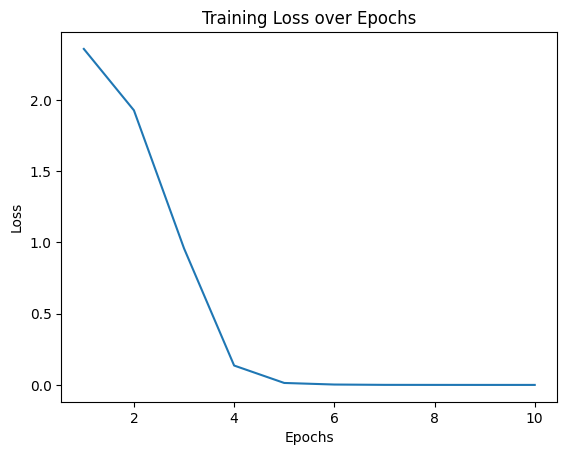

In [ ]:
#plot training loss
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()
